# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import struct
from array import array

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

#We use Struct to unpack the binary data structure
def load(path_img, path_lbl):
        with open(path_lbl, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049,'
                                 'got {}'.format(magic))
            labels = array("B", file.read())

        with open(path_img, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051,'
                                 'got {}'.format(magic))

            image_data = array("B", file.read())

        images = []
        print("loaind {} images".format(size))
        for i in range(size):
            images.append([0] * rows * cols)

        for i in range(size):
            images[i][:] = image_data[i*rows*cols:(i + 1) * rows * cols]

        return images, labels

train_dataset, train_labels = load('train-images-idx3-ubyte','train-labels-idx1-ubyte')


loaind 60000 images


In [2]:
from sklearn.model_selection import train_test_split
train, validation, t_labels, v_labels = train_test_split(train_dataset, train_labels, test_size=0.33, random_state=42)

(28, 28)
3


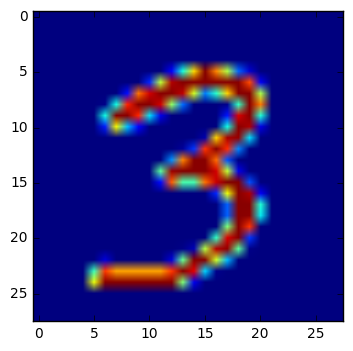

In [121]:
index = 999
img = np.asarray(train[index]).reshape(28,28)
plt.imshow(img)
print(img.shape)
print(bytes(t_labels[index]).decode('utf-8'))

In [158]:
def concat_images(imga, imgb):
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width, 3), dtype=np.uint8)
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img


In [159]:
from scipy import ndimage
from scipy.misc import imresize
import random

IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 11 # 0-9 and no digit (10)
N = 5 # max number of digits on the sequence

np.random.seed(42)
  
def create_sequences(images, labels):
  
  #if type(train_labels[0]).__module__ == np.__name__:
  #  print('Sequence already created')
  #  return images, labels
  
  length = len(images)
  index = 0
  seq_images = np.ndarray([length,IMAGE_SIZE,IMAGE_SIZE,NUM_CHANNELS], dtype='float32')
  seq_labels = np.ones([length, N], dtype=int) * 10 # init to 10 cause it would be no digit
  
  while index < length:
    # Random
    L = random.randint(1, N)
    # Image
    selected = []
    i=0
    while i<L:
        offset = random.randint(0, length-N)
        im = np.asarray(images[offset]).reshape(28,28)
        selected.append(im)
        seq_labels[index,N-L+i]=labels[offset]
        i=i+1
    sequence = np.hstack(selected)
    sequence_resized = imresize(sequence, (28,28)) #28x28
    sequence_resized = sequence_resized.reshape((28, 28, NUM_CHANNELS)).astype(np.float32) #28x28x1
    
    seq_images[index] = sequence_resized
      
    index += 1
      
  return seq_images, seq_labels

In [160]:

strain_dataset, st_labels = create_sequences(train, t_labels)
svalid_dataset, sv_labels = create_sequences(validation, v_labels)

[6 2 5 6 0]


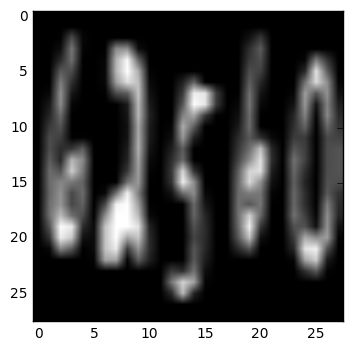

In [161]:
index = 22
print(sv_labels[index])
im = svalid_dataset[index].reshape(28,28)
plt.imshow(im,cmap='gray')
plt.show()
#test_dataset, test_labels = create_sequences(test_dataset, test_labels)


#print('Training set', strain_dataset.shape, st_labels.shape)
#print('Validation set', valid_dataset.shape, valid_labels.shape)
#print('Test set', test_dataset.shape, test_labels.shape)  

We define some auxiliary functions such:

accuracy: 
pred_acc:
check_prediction

In [10]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

def pred_acc(predictions, labels):
  return (100.0 * np.sum(predictions == labels) / predictions.shape[1] / predictions.shape[0])


Creating the Convolutional Neural Network

In [11]:
import tensorflow as tf

IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 11
N = 5

BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 32
DEPTH_3 = 64
NODES = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  tf_train_labels  = tf.placeholder(tf.int64, shape=(BATCH_SIZE, N))
  tf_valid_dataset = tf.constant(svalid_dataset)
  #tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # 5x5 Filter, depth 16 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 5x5 Filter, depth 32
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))
  
  # 5x5 Filter, depth 64
  conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_3]))

  # Linear 
  N1_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS],stddev=0.1))
  N1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N2_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
  N2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N3_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
  N3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N4_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
  N4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N5_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
  N5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  # Model.
  def model(data):
    
    kernel1 = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, conv1_biases))
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm1 = tf.nn.local_response_normalization(pool1)
    
    kernel2 = tf.nn.conv2d(norm1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, conv2_biases))
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm2 = tf.nn.local_response_normalization(pool2)

    kernel3 = tf.nn.conv2d(norm2, conv3_weights, [1, 1, 1, 1], padding='VALID')
    conv3 = tf.nn.relu(tf.nn.bias_add(kernel3, conv3_biases))
    norm3 = tf.nn.local_response_normalization(conv3)
    pool = tf.nn.max_pool(norm3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #pool = norm3
    
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    
    # Linear Extraction for each component
    feature_1 = tf.nn.bias_add(tf.matmul(reshape, N1_weights), N1_biases)
    feature_2 = tf.nn.bias_add(tf.matmul(reshape, N2_weights), N2_biases)
    feature_3 = tf.nn.bias_add(tf.matmul(reshape, N3_weights), N3_biases)
    feature_4 = tf.nn.bias_add(tf.matmul(reshape, N4_weights), N4_biases)
    feature_5 = tf.nn.bias_add(tf.matmul(reshape, N5_weights), N5_biases)
    
    return feature_1, feature_2, feature_3, feature_4, feature_5

  logits1, logits2, logits3, logits4, logits5 = model(tf_train_dataset)
  l1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,0]))
  l2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,1]))
  l3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,2]))
  l4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,3]))
  l5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,4]))
  
  loss = l1+l2+l3+l4+l5
    
  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset)[0]),\
                      tf.nn.softmax(model(tf_train_dataset)[1]),\
                      tf.nn.softmax(model(tf_train_dataset)[2]),\
                      tf.nn.softmax(model(tf_train_dataset)[3]),\
                      tf.nn.softmax(model(tf_train_dataset)[4])])
  valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset)[4])])
  
  saver = tf.train.Saver()

NameError: name 'svalid_dataset' is not defined

In [164]:
NUM_STEPS = 20001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  #sp = saver.restore(session, "MNIST-CNN-sequence-1.ckpt")
  print('Model Restored')
  print('Initialized')
  for step in range(NUM_STEPS):    
    offset = (step * BATCH_SIZE) % (st_labels.shape[0] - BATCH_SIZE)
    batch_data = strain_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = st_labels[offset:(offset + BATCH_SIZE),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), sv_labels))
  #sp = saver.save(session, "MNIST-CNN-sequence-1.ckpt")
  print('Model Saved')
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Model Restored
Initialized
Minibatch loss at step 0: 12.348434
Minibatch accuracy: 7.2%
Validation accuracy: 6.0%
Minibatch loss at step 500: 7.427956
Minibatch accuracy: 44.7%
Validation accuracy: 46.2%
Minibatch loss at step 1000: 6.969615
Minibatch accuracy: 52.8%
Validation accuracy: 51.9%
Minibatch loss at step 1500: 7.318340
Minibatch accuracy: 52.5%
Validation accuracy: 57.7%
Minibatch loss at step 2000: 6.730289
Minibatch accuracy: 60.9%
Validation accuracy: 62.9%
Minibatch loss at step 2500: 5.405299
Minibatch accuracy: 69.7%
Validation accuracy: 66.3%
Minibatch loss at step 3000: 5.498006
Minibatch accuracy: 69.4%
Validation accuracy: 69.1%
Minibatch loss at step 3500: 5.452298
Minibatch accuracy: 68.8%
Validation accuracy: 71.7%
Minibatch loss at step 4000: 4.455705
Minibatch accuracy: 75.0%
Validation accuracy: 73.5%
Minibatch loss at step 4500: 3.953049
Minibatch accuracy: 77.8%
Validation accuracy: 75.4%
Minibatch loss at step 5000: 4.197549
Minibatch accuracy: 75.6%
Vali

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result



In [4]:
train_folders = 'sv_train/train'
test_folders = 'test'
extra_folders = 'extra'
fin = os.path.join(train_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()

deal with numb

In [22]:
from PIL import Image

SV_IMG_SIZE = 50
SV_CHANNELS = 1
train_imsize = np.ndarray([len(train_data),2])
k = 500
sv_images = []
max_images = 500#len(train_data)
max_digits = 5
sv_labels = np.ones([max_images, max_digits], dtype=int) * 10 # init to 10 cause it would be no digit
 

for i in range(max_images):
    print (" \r%d" % i,end="")
    filename = train_data[i]['filename']
    fullname = os.path.join(train_folders, filename)
    boxes = train_data[i]['boxes']
    label = [10,10,10,10,10]
    lb = len(boxes)
    if lb <= max_digits:
        im = Image.open(fullname)
        for bid,box in  enumerate(boxes):
            sv_labels[i][max_digits-lb+bid] = int(box['label'])
            #im2= im.crop((box['left']
            #       ,box['top']
            #       ,box['left']+box['width']
            #       ,box['top']+box['height']))
        im = im.resize((SV_IMG_SIZE,SV_IMG_SIZE),Image.ANTIALIAS)
        array = np.asarray(im)
        array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,3)).astype(np.float32)
        na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE],dtype=int)
        for x in range (array.shape[0]):
            for y in range (array.shape[1]):
                na[x][y]=np.average(array[x][y][:])
        na = na.reshape(SV_IMG_SIZE,SV_IMG_SIZE,1)
        #print(array.shape)
        sv_images.append(na.astype(np.float32))

idx = 2
sv_images = np.asarray(sv_images)


499

In [24]:
from sklearn.model_selection import train_test_split
sv_train, sv_validation, svt_labels, svv_labels = train_test_split(sv_images, sv_labels, test_size=0.33, random_state=42)

In [26]:
import tensorflow as tf

IMAGE_SIZE = SV_IMG_SIZE
NUM_CHANNELS = SV_CHANNELS
NUM_LABELS = 11
N = 5

BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 16
DEPTH_3 = 32
NODES = 512

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  tf_train_labels  = tf.placeholder(tf.int64, shape=(BATCH_SIZE, N))
  tf_valid_dataset = tf.constant(sv_validation)
  #tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # 5x5 Filter, depth 16 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 5x5 Filter, depth 32
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))
  
  # 5x5 Filter, depth 64
  conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_3]))

  # Linear 
  N1_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS],stddev=0.1))
  N1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N2_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
  N2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N3_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
  N3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N4_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
  N4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N5_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
  N5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  # Model. A Athree layers CNN is trained five times to recognize each single digit
  def sv_model(data):
    kernel1 = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, conv1_biases))
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm1 = tf.nn.local_response_normalization(pool1)
    
    kernel2 = tf.nn.conv2d(norm1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, conv2_biases))
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm2 = tf.nn.local_response_normalization(pool2)

    kernel3 = tf.nn.conv2d(norm2, conv3_weights, [1, 1, 1, 1], padding='VALID')
    conv3 = tf.nn.relu(tf.nn.bias_add(kernel3, conv3_biases))
    norm3 = tf.nn.local_response_normalization(conv3)
    pool = tf.nn.max_pool(norm3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #pool = norm3
    
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    
    # Linear Extraction for each component
    # Five Weights matrices are trained for each digits with the same model
    feature_1 = tf.nn.bias_add(tf.matmul(reshape, N1_weights), N1_biases)
    feature_2 = tf.nn.bias_add(tf.matmul(reshape, N2_weights), N2_biases)
    feature_3 = tf.nn.bias_add(tf.matmul(reshape, N3_weights), N3_biases)
    feature_4 = tf.nn.bias_add(tf.matmul(reshape, N4_weights), N4_biases)
    feature_5 = tf.nn.bias_add(tf.matmul(reshape, N5_weights), N5_biases)
    
    return feature_1, feature_2, feature_3, feature_4, feature_5

  logits1, logits2, logits3, logits4, logits5 = sv_model(tf_train_dataset)
  l1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,0]))
  l2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,1]))
  l3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,2]))
  l4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,3]))
  l5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,4]))
  
  loss = l1+l2+l3+l4+l5
    
  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.pack([tf.nn.softmax(sv_model(tf_train_dataset)[0]),\
                      tf.nn.softmax(sv_model(tf_train_dataset)[1]),\
                      tf.nn.softmax(sv_model(tf_train_dataset)[2]),\
                      tf.nn.softmax(sv_model(tf_train_dataset)[3]),\
                      tf.nn.softmax(sv_model(tf_train_dataset)[4])])
  valid_prediction = tf.pack([tf.nn.softmax(sv_model(tf_valid_dataset)[0]),\
                      tf.nn.softmax(sv_model(tf_valid_dataset)[1]),\
                      tf.nn.softmax(sv_model(tf_valid_dataset)[2]),\
                      tf.nn.softmax(sv_model(tf_valid_dataset)[3]),\
                      tf.nn.softmax(sv_model(tf_valid_dataset)[4])])
  
  saver = tf.train.Saver()

In [27]:
NUM_STEPS = 20001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  #sp = saver.restore(session, "MNIST-CNN-sequence-1.ckpt")
  print('Model Restored')
  print('Initialized')
  for step in range(NUM_STEPS):   
    perc = float(step/NUM_STEPS)
    print(" \r%d complete" % step, end="") 
    offset = (step * BATCH_SIZE) % (svt_labels.shape[0] - BATCH_SIZE)
    batch_data = sv_train[offset:(offset + BATCH_SIZE), :, :]
    batch_labels = svt_labels[offset:(offset + BATCH_SIZE),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('\nMinibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), svv_labels))
  #sp = saver.save(session, "MNIST-CNN-sequence-1.ckpt")
  print('Model Saved')
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Model Restored
Initialized
0 complete
Minibatch loss at step 0: 13.390993
Minibatch accuracy: 3.8%
Validation accuracy: 43.3%
100 complete
Minibatch loss at step 100: 5.383161
Minibatch accuracy: 63.8%
Validation accuracy: 57.5%
200 complete
Minibatch loss at step 200: 5.918910
Minibatch accuracy: 59.1%
Validation accuracy: 58.9%
300 complete
Minibatch loss at step 300: 5.861883
Minibatch accuracy: 58.4%
Validation accuracy: 58.5%
400 complete
Minibatch loss at step 400: 5.883329
Minibatch accuracy: 56.9%
Validation accuracy: 57.7%
500 complete
Minibatch loss at step 500: 5.671009
Minibatch accuracy: 61.9%
Validation accuracy: 58.8%
600 complete
Minibatch loss at step 600: 5.009953
Minibatch accuracy: 67.5%
Validation accuracy: 58.8%
700 complete
Minibatch loss at step 700: 5.246472
Minibatch accuracy: 66.9%
Validation accuracy: 59.2%
800 complete
Minibatch loss at step 800: 5.079862
Minibatch accuracy: 65.9%
Validation accuracy: 58.8%
900 complete
Minibatch loss at step 900: 3.962049


KeyboardInterrupt: 

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

tried with 3 channels
now trying with 1
turned to 1 things get far better

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.
import h5py
labels_file = './sv/train/digitStruct.mat'
f = h5py.File(labels_file)
k = f.values()
names = k[1].values()
print(names[0][0][0])


### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [354]:
from PIL import Image
max_images = 1000
SV_IMG_SIZE = 40
SV_CHANNELS = 1
max_digits = 5
sv_images = []
sv_boxes = []

for i in range(max_images):
    print (" \r%d" % i,end="")
    filename = train_data[i]['filename']
    fullname = os.path.join(train_folders, filename)
    boxes = train_data[i]['boxes']
    lb = len(boxes)
    if lb <= max_digits:
        im = Image.open(fullname)
        owidth, oheight = im.size
        im = im.resize((SV_IMG_SIZE,SV_IMG_SIZE),Image.ANTIALIAS)
        array = np.asarray(im)
        array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,3)).astype(np.float32)
        na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE],dtype=int)
        for x in range (array.shape[0]):
            for y in range (array.shape[1]):
                na[x][y]=np.average(array[x][y][:])
        digitsCount = len(boxes)
        box_list=[digitsCount]
        wr = SV_IMG_SIZE/float(owidth)
        hr = SV_IMG_SIZE/float(oheight)
        #TODO RESIZE BOX ACCORDING TO IMAGE
        for bid,box in  enumerate(boxes):
            nbox = [box['left']*wr
                    ,box['top'] *hr
                    ,(box['left']+box['width'])*wr
                    ,(box['top']+box['height'])*hr]
            box_list = box_list + nbox
        left = max_digits -lb
        while left>0:
            box_list = box_list+ [0,0,0,0]
            left= left-1
        box_list = np.ceil(np.asarray(box_list))
        na = na.reshape(SV_IMG_SIZE,SV_IMG_SIZE,1)
        sv_images.append(na.astype(np.float32))
        sv_boxes.append(box_list)

idx = 2
sv_images = np.asarray(sv_images)

999

(40, 40, 1)


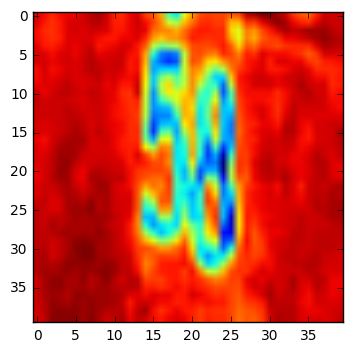

In [121]:
print(sv_images[1].shape)
plt.imshow(sv_images[13].reshape(40,40))
plt.show()

In [355]:
from sklearn.model_selection import train_test_split
sv_train, sv_validation, svt_boxes, svv_boxes = train_test_split(sv_images, sv_boxes, test_size=0.33, random_state=42)

In [374]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def iou (box1,box2):
    if box1[0]==0 and box2[0]<=0:
        return 1
    dx = min(box1[0]+box1[2] ,box2[0]+box2[2]) - max(box1[0], box2[0])
    dy = min(box1[1]+box1[3] ,box2[1]+box2[3]) - max(box1[1], box2[1])
    if dx < 0 or dy < 0:
        return 0
    overlapArea = dx*dy;  
    a1 = box1[2]*box1[3] +1
    a2 = box2[2]*box2[3] +1
    IoU = overlapArea / float(a1 + a2 - overlapArea)
    if IoU <0:
        return 0
    return IoU

def tensoriou(box1,box2):
    dx = tf.minimum(box1[0]+box1[2] ,box2[0]+box2[2]) - tf.maximum(box1[0], box2[0])
    dy = tf.minimum(box1[1]+box1[3] ,box2[1]+box2[3]) - tf.maximum(box1[1], box2[1])
    
    overlapArea = dx*dy;  
    a1 = tf.multiply(box1[2],box1[3]) +1
    a2 = tf.multiply(box2[2],box2[3]) +1
    IoU = overlapArea / a1 + a2 - overlapArea
    return IoU

def iouseq(predictions,labels):
    ba = list(chunks(predictions[1:],4))
    bb = list(chunks(labels[1:],4)) 
    ious = []
    for bid,ba1 in enumerate(ba):
        box1 = ba1
        box2 = bb[bid]
        ious.append(iou(box1,box2))
    return ious

def iouall(predictions,labels):
    res = []
    for pid, pred in enumerate(predictions):
        ious = iouseq(pred,labels[pid])
        res.append(np.sum(ious))
    return res

In [375]:
def box_accuracy(predictions, labels):
    IoU = iouall(predictions,labels)
    return (100.0 * np.sum(IoU) / predictions.shape[1] / predictions.shape[0])

In [378]:
tf.reset_default_graph()

graph = tf.Graph()
N=20
NUM_CHANNELS = 1
NUM_LABELS = 21
NODES = 288

BATCH_SIZE = 64

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=[BATCH_SIZE, SV_IMG_SIZE,SV_IMG_SIZE,NUM_CHANNELS])
  tf_train_labels  = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_LABELS])
  tf_valid_dataset = tf.constant(sv_validation)
  #tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # 5x5 Filter, depth 16 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 5x5 Filter, depth 32
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))
  
  # 5x5 Filter, depth 64
  conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_3]))

  # Linear 
  N0_weights = tf.Variable(tf.truncated_normal([NODES,1],stddev=1))
  N0_biases = tf.Variable(tf.constant(1.0,shape=[1]))
    
  N1_weights = tf.Variable(tf.truncated_normal([NODES, 4],stddev=1))
  N1_biases = tf.Variable(tf.constant(1.0, shape=[4]))
  
  N2_weights = tf.Variable(tf.truncated_normal([NODES, 4], stddev=1))
  N2_biases = tf.Variable(tf.constant(1.0, shape=[4]))
  
  N3_weights = tf.Variable(tf.truncated_normal([NODES, 4], stddev=1))
  N3_biases = tf.Variable(tf.constant(1.0, shape=[4]))
  
  N4_weights = tf.Variable(tf.truncated_normal([NODES, 4], stddev=1))
  N4_biases = tf.Variable(tf.constant(1.0, shape=[4]))
  
  N5_weights = tf.Variable(tf.truncated_normal([NODES, 4], stddev=1))
  N5_biases = tf.Variable(tf.constant(1.0, shape=[4]))
  
  # Model. A Athree layers CNN is trained five times to recognize each single digit
  def sv_model(data):
    kernel1 = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, conv1_biases))
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm1 = tf.nn.local_response_normalization(pool1)
    
    kernel2 = tf.nn.conv2d(norm1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, conv2_biases))
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm2 = tf.nn.local_response_normalization(pool2)

    kernel3 = tf.nn.conv2d(norm2, conv3_weights, [1, 1, 1, 1], padding='VALID')
    conv3 = tf.nn.relu(tf.nn.bias_add(kernel3, conv3_biases))
    norm3 = tf.nn.local_response_normalization(conv3)
    pool = tf.nn.max_pool(norm3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #pool = norm3
    
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    
    # Linear Extraction for each component
    # Five Weights matrices are trained for each digits with the same model
    feature_0 = tf.nn.bias_add(tf.matmul(reshape, N0_weights), N0_biases)
    feature_1 = tf.nn.bias_add(tf.matmul(reshape, N1_weights), N1_biases)
    feature_2 = tf.nn.bias_add(tf.matmul(reshape, N2_weights), N2_biases)
    feature_3 = tf.nn.bias_add(tf.matmul(reshape, N3_weights), N3_biases)
    feature_4 = tf.nn.bias_add(tf.matmul(reshape, N4_weights), N4_biases)
    feature_5 = tf.nn.bias_add(tf.matmul(reshape, N5_weights), N5_biases)
    
    return feature_0, feature_1, feature_2, feature_3, feature_4, feature_5

  logit0, logits1, logits2, logits3, logits4, logits5 = sv_model(tf_train_dataset)
  

  l0 = tf.reduce_mean(tf.nn.l2_loss(logit0 -tf_train_labels[:,0]))  
  l1 = tf.reduce_mean(tf.nn.l2_loss(logits1-tf_train_labels[:,1:5]))
  l2 = tf.reduce_mean(tf.nn.l2_loss(logits2-tf_train_labels[:,5:9]))
  l3 = tf.reduce_mean(tf.nn.l2_loss(logits3-tf_train_labels[:,9:13]))
  l4 = tf.reduce_mean(tf.nn.l2_loss(logits4-tf_train_labels[:,13:17]))
  l5 = tf.reduce_mean(tf.nn.l2_loss(logits5-tf_train_labels[:,17:21]))

  
  
  loss = l0+l1+l2+l3+l4+l5
    
  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(0.1).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.concat(1,[(sv_model(tf_train_dataset)[0]),\
                              (sv_model(tf_train_dataset)[1]),\
                              (sv_model(tf_train_dataset)[2]),\
                              (sv_model(tf_train_dataset)[3]),\
                              (sv_model(tf_train_dataset)[4])])
  print(train_prediction)
  
  valid_prediction = tf.concat(1,[(sv_model(tf_valid_dataset)[0]),\
                              (sv_model(tf_valid_dataset)[1]),\
                              (sv_model(tf_valid_dataset)[2]),\
                              (sv_model(tf_valid_dataset)[3]),\
                              (sv_model(tf_valid_dataset)[4])])
  
  saver = tf.train.Saver()

Tensor("concat:0", shape=(64, 17), dtype=float32)


In [379]:
NUM_STEPS = 20001
svt_boxes =np.asarray(svt_boxes)
svv_boxes =np.asarray(svv_boxes)
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  #sp = saver.restore(session, "MNIST-CNN-sequence-1.ckpt")
  print('Model Restored')
  print('Initialized')
  for step in range(NUM_STEPS):   
    perc = float(step/NUM_STEPS)
    print(" \r%d complete" % step, end="") 
    offset = (step * BATCH_SIZE) % (svt_boxes.shape[0] - BATCH_SIZE)
    batch_data = sv_train[offset:(offset + BATCH_SIZE), :, :]
    batch_labels = svt_boxes[offset:(offset + BATCH_SIZE),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('\nMinibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % box_accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % box_accuracy(valid_prediction.eval(), svv_boxes))
      print(np.ceil(predictions[0]))
      print(np.ceil(batch_labels[0]))

Model Restored
Initialized
0 complete
Minibatch loss at step 0: 141057.750000
Minibatch accuracy: 0.0%
Validation accuracy: 1.1%
[  4.  -2.   4.   5.   3.  14.  -3.  -1.  -2.   4.  -0.   3.   3.   5.   7.
  -0.  -9.]
[  3.  12.   3.  19.  26.  16.   6.  22.  29.  20.  11.  25.  34.   0.   0.
   0.   0.   0.   0.   0.   0.]
100 complete
Minibatch loss at step 100: 35633.281250
Minibatch accuracy: 6.6%
Validation accuracy: 6.4%
[  3.  15.   8.  20.  34.  18.   7.  22.  29.   7.   3.   8.   9.   1.   1.
   2.   2.]
[  1.  19.   7.  24.  33.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
200 complete
Minibatch loss at step 200: 26321.248047
Minibatch accuracy: 6.5%
Validation accuracy: 6.4%
[  3.  15.   8.  21.  34.  17.   7.  22.  29.   7.   3.   8.   9.   1.   1.
   1.   1.]
[  1.  15.   4.  25.  33.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
300 complete
Minibatch loss at step 300: 32476.691406
Minibatch accuracy:

KeyboardInterrupt: 

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.